In [1]:
import numpy as np
import pandas as pd
from textwrap import wrap
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as mticker
import sys, os
from topicpy.hsbmpy import plot_topic_size, get_max_available_L
from topicpy.hypergeom import parameters_for_hypergeometric, build_map, plot_map

In [2]:
directory=f"/home/jovyan/work/phd/datasets/tcga/BRCA/mirna/"
os.chdir(directory)

In [3]:
L = get_max_available_L(directory, "trisbm")

In [4]:
os.listdir()

['trisbm',
 'mainTable_hv.csv',
 '.empty',
 'Enrichr',
 'mainTable_all.csv',
 'gback.txt',
 'files.dat',
 'gsea',
 'gback_ensg.txt',
 'topsbm']

# Geneontology

In [5]:
from topicpy.geneontology import get_ontology_df, ensg_to_symbol
from topicpy.tableanalyser import get_symbol
import gseapy as gs

In [52]:
l=L-1
algorithm = "trisbm"
kind = "keyword", "metadata"
kind = "word", "topics"
df_topics = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_{kind[1]}.csv")
df_topics_smooth = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_{kind[0]}-dist.csv",index_col=0)
df_topics_smooth.index = [g[:15] for g in df_topics_smooth.index]
print(f"level {l} with {df_topics.shape[1]} {kind[1]}")

level 1 with 9 topics


In [53]:
def get_topic_over_thr(topic_name, q=0.05):
    topic = df_topics_smooth[topic_name]
    topic = topic[topic>0]
    topic = topic[topic>topic.quantile(q=q)]
    return topic.sort_values(ascending=False)

In [54]:
df_symbols= pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_pub_ensembl_id&col=md_ensembl_id&col=md_eg_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit", index_col=[0], sep='\t')

In [55]:
def get_sea():
    for g in df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]:
        yield get_symbol(g)

In [56]:
with open(f"gback_{kind[0]}.txt",'w') as f:
    list(map(lambda x: f.writelines(x+'\n') if len(x)>1 else None, get_sea()))
    
with open(f"gback_ensg_{kind[0]}.txt",'w') as f:
    list(map(lambda x: f.writelines(x[:15]+'\n')if len(x)>1 else None, df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]))

In [57]:
#gs.get_library_name()

In [58]:
#https://www.gsea-msigdb.org/gsea/downloads.jsp
gene_sets = ['GO_Molecular_Function_2018',
             'GO_Biological_Process_2018',
             'GO_Cellular_Component_2018',
             'Human_Phenotype_Ontology',
             'WikiPathways_2019_Human',
             '/home/jovyan/work/phd/MSigDB/c1.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c2.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c3.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c4.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c5.all.v7.1.symbols.gmt',
           #  '/home/jovyan/work/phd/MSigDB/c6.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c7.all.v7.1.symbols.gmt',
            ]

In [59]:
threshhold = 5e-1
cutoff = 5e-1
background = len([g for g in get_sea()])
os.system("mkdir -p gsea")
os.system("mkdir -p gsea/{}".format(algorithm))
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("gsea/%s/gsea_level_%d_%s_%d.csv"%(algorithm,l,kind[1],itopic+1), index_col=[0])
        print(topic)
    except:
        try:
            gene_list = ensg_to_symbol(df_topics.loc[:,topic].dropna().values)
            #gene_list = ensg_to_symbol(get_topic_over_thr(topic).index)
            #gene_list = list(df_topics.loc[:,topic].dropna().values)
            print(topic)
            enriched_topic = get_ontology_df(gene_list, cutoff=cutoff, threshhold = threshhold, gene_sets = gene_sets, background=background)
            enriched_topic = enriched_topic.sort_values(by=['Adjusted P-value'], ascending=True)[:20]
            enriched_topic.to_csv("gsea/%s/gsea_level_%d_%s_%d.csv"%(algorithm,l,kind[1],itopic+1))
        except:
            print(*sys.exc_info())
            continue
    print(enriched_topic)

Topic 1


2021-02-19 14:48:30,931 Warning: No enrich terms using library CUSTOM139686238080064 when cutoff = 0.5
2021-02-19 14:48:32,126 Warning: No enrich terms using library CUSTOM139686238077760 when cutoff = 0.5
2021-02-19 14:48:33,064 Warning: No enrich terms using library CUSTOM139686238079104 when cutoff = 0.5
2021-02-19 14:48:33,266 Warning: No enrich terms using library CUSTOM139686238080192 when cutoff = 0.5
2021-02-19 14:48:35,090 Warning: No enrich terms using library CUSTOM139686238078528 when cutoff = 0.5
2021-02-19 14:48:36,387 Warning: No enrich terms using library CUSTOM139686238080704 when cutoff = 0.5


                                                   Term  Adjusted P-value  \
606    cytokine-mediated signaling pathway (GO:0019221)      4.457183e-08   
5127              Nuclear Receptors Meta-Pathway WP2882      8.163332e-08   
608   neutrophil activation involved in immune respo...      2.664862e-05   
609           neutrophil mediated immunity (GO:0002446)      2.664862e-05   
607               neutrophil degranulation (GO:0043312)      2.664862e-05   
3832               secretory granule lumen (GO:0034774)      5.935423e-05   
5128                                   Cell Cycle WP179      6.454141e-05   
3833                ficolin-1-rich granule (GO:0101002)      1.983064e-04   
612      extracellular matrix organization (GO:0030198)      2.957390e-04   
611   cellular response to cytokine stimulus (GO:007...      2.957390e-04   
610   negative regulation of signal transduction (GO...      2.957390e-04   
5130                          Copper homeostasis WP3286      5.295342e-04   

2021-02-19 14:48:55,712 Warning: No enrich terms using library CUSTOM139686239138560 when cutoff = 0.5
2021-02-19 14:48:56,479 Warning: No enrich terms using library CUSTOM139686239140352 when cutoff = 0.5
2021-02-19 14:48:57,221 Warning: No enrich terms using library CUSTOM139686239138304 when cutoff = 0.5
2021-02-19 14:48:57,358 Warning: No enrich terms using library CUSTOM139686239138240 when cutoff = 0.5
2021-02-19 14:48:58,455 Warning: No enrich terms using library CUSTOM139686239138368 when cutoff = 0.5
2021-02-19 14:48:59,728 Warning: No enrich terms using library CUSTOM139686239139200 when cutoff = 0.5


                                                   Term  Adjusted P-value  \
380   positive regulation of cell differentiation (G...          0.011295   
3103              White fat cell differentiation WP4149          0.019773   
3104  Chromosomal and microsatellite instability in ...          0.019773   
3105                  Vitamin D Receptor Pathway WP2877          0.019773   
3106  Myometrial Relaxation and Contraction Pathways...          0.019773   
381              regulation of JNK cascade (GO:0046328)          0.020579   
3107                               Focal Adhesion WP306          0.024872   
3108  Hair Follicle Development: Cytodifferentiation...          0.024872   
3109                    Endochondral Ossification WP474          0.024872   
3110                      PPAR signaling pathway WP3942          0.025884   
3111  LncRNA involvement in canonical Wnt signaling ...          0.025884   
3112              Nuclear Receptors Meta-Pathway WP2882          0.025884   

2021-02-19 14:49:18,008 Warning: No enrich terms using library CUSTOM139686249559744 when cutoff = 0.5
2021-02-19 14:49:18,701 Warning: No enrich terms using library CUSTOM139686249559616 when cutoff = 0.5
2021-02-19 14:49:19,355 Warning: No enrich terms using library CUSTOM139686249561024 when cutoff = 0.5
2021-02-19 14:49:19,458 Warning: No enrich terms using library CUSTOM139686249559680 when cutoff = 0.5
2021-02-19 14:49:20,400 Warning: No enrich terms using library CUSTOM139686249561088 when cutoff = 0.5
2021-02-19 14:49:21,411 Warning: No enrich terms using library CUSTOM139686249561216 when cutoff = 0.5


                                                  Term  Adjusted P-value  \
298                    muscle contraction (GO:0006936)      2.525651e-08   
299     actomyosin structure organization (GO:0031032)      9.376455e-07   
300                    myofibril assembly (GO:0030239)      2.962585e-06   
2426         Striated Muscle Contraction Pathway WP383      4.476053e-06   
301                sarcomere organization (GO:0045214)      3.438737e-05   
302   cardiac muscle tissue morphogenesis (GO:0055008)      8.281969e-05   
304         actin-myosin filament sliding (GO:0033275)      8.755837e-05   
303               muscle filament sliding (GO:0030049)      8.755837e-05   
305                 inflammatory response (GO:0006954)      1.329645e-04   
306           striated muscle contraction (GO:0006941)      1.512869e-04   
2427                         Spinal Cord Injury WP2431      2.747276e-04   
307           skeletal muscle contraction (GO:0003009)      3.415825e-04   
1882        

2021-02-19 14:49:39,333 Warning: No enrich terms using library CUSTOM139686255841664 when cutoff = 0.5
2021-02-19 14:49:39,952 Warning: No enrich terms using library CUSTOM139686255824576 when cutoff = 0.5
2021-02-19 14:49:40,538 Warning: No enrich terms using library CUSTOM139686257823168 when cutoff = 0.5
2021-02-19 14:49:40,636 Warning: No enrich terms using library CUSTOM139686255844096 when cutoff = 0.5
2021-02-19 14:49:41,553 Warning: No enrich terms using library CUSTOM139686257821120 when cutoff = 0.5
2021-02-19 14:49:42,591 Warning: No enrich terms using library CUSTOM139686257820416 when cutoff = 0.5


                                                   Term  Adjusted P-value  \
1821                         lipid droplet (GO:0005811)          0.000679   
280            striated muscle contraction (GO:0006941)          0.007192   
2528                   Triacylglyceride Synthesis WP325          0.025470   
281            skeletal muscle contraction (GO:0003009)          0.029758   
282   positive regulation of lipase activity (GO:006...          0.057332   
283   regulation of phospholipase activity (GO:0010517)          0.057332   
0         endopeptidase inhibitor activity (GO:0004866)          0.063971   
1926                  Acanthosis nigricans (HP:0000956)          0.090483   
1927                  Hypertriglyceridemia (HP:0002155)          0.093880   
284   regulation of macrophage differentiation (GO:0...          0.094572   
285          negative regulation of growth (GO:0045926)          0.094572   
286   regulation of B cell differentiation (GO:0045577)          0.111265   

2021-02-19 14:49:58,931 Warning: No enrich terms using library CUSTOM139686260335232 when cutoff = 0.5
2021-02-19 14:49:59,269 Warning: No enrich terms using library CUSTOM139686260335360 when cutoff = 0.5
2021-02-19 14:49:59,676 Warning: No enrich terms using library CUSTOM139686260335104 when cutoff = 0.5
2021-02-19 14:50:00,346 Warning: No enrich terms using library CUSTOM139686260335040 when cutoff = 0.5
2021-02-19 14:50:00,993 Warning: No enrich terms using library CUSTOM139686260334912 when cutoff = 0.5


                                                   Term  Adjusted P-value  \
165                muscle filament sliding (GO:0030049)          0.000036   
166          actin-myosin filament sliding (GO:0033275)          0.000036   
1238          Striated Muscle Contraction Pathway WP383          0.000296   
167                      heart contraction (GO:0060047)          0.001363   
168                  peptide cross-linking (GO:0018149)          0.001363   
169                  epidermis development (GO:0008544)          0.001363   
170                     muscle contraction (GO:0006936)          0.002357   
171         epidermal cell differentiation (GO:0009913)          0.005314   
172             cardiac muscle contraction (GO:0060048)          0.005590   
905       Type 1 muscle fiber predominance (HP:0003803)          0.006030   
835                          lamellar body (GO:0042599)          0.006685   
906         Autosomal dominant inheritance (HP:0000006)          0.009331   

2021-02-19 14:50:16,113 Warning: No enrich terms using library CUSTOM139686253196864 when cutoff = 0.5
2021-02-19 14:50:16,232 Warning: No enrich terms using library CUSTOM139686253197824 when cutoff = 0.5
2021-02-19 14:50:16,472 Warning: No enrich terms using library CUSTOM139686253195712 when cutoff = 0.5
2021-02-19 14:50:16,502 Warning: No enrich terms using library CUSTOM139686253196736 when cutoff = 0.5
2021-02-19 14:50:16,689 Warning: No enrich terms using library CUSTOM139686253195840 when cutoff = 0.5
2021-02-19 14:50:16,917 Warning: No enrich terms using library CUSTOM139686253197632 when cutoff = 0.5


                                                  Term  Adjusted P-value  \
0    peptidyl-proline 4-dioxygenase activity (GO:00...          0.165032   
1    protein-glutamine gamma-glutamyltransferase ac...          0.165032   
2    peptidyl-proline dioxygenase activity (GO:0031...          0.165032   
3                      telethonin binding (GO:0031433)          0.165032   
205                   Metatarsus adductus (HP:0001840)          0.166423   
204                         Hypotrichosis (HP:0001006)          0.166423   
203                           Absent hair (HP:0002298)          0.166423   
202                             Ectropion (HP:0000656)          0.166423   
201   Abnormality of the calf musculature (HP:0001430)          0.166423   
200  Congenital ichthyosiform erythroderma (HP:0007...          0.166423   
199  Abnormality of the vertebral endplates (HP:000...          0.166423   
198                             Bone cyst (HP:0012062)          0.166423   
197         

2021-02-19 14:50:32,556 Warning: No enrich terms using library CUSTOM139686248157824 when cutoff = 0.5
2021-02-19 14:50:32,819 Warning: No enrich terms using library CUSTOM139686248157696 when cutoff = 0.5
2021-02-19 14:50:33,157 Warning: No enrich terms using library CUSTOM139686248157952 when cutoff = 0.5
2021-02-19 14:50:33,232 Warning: No enrich terms using library CUSTOM139686248157760 when cutoff = 0.5
2021-02-19 14:50:33,772 Warning: No enrich terms using library CUSTOM139686248158016 when cutoff = 0.5
2021-02-19 14:50:34,286 Warning: No enrich terms using library CUSTOM139686248158144 when cutoff = 0.5


                                                  Term  Adjusted P-value  \
737  spherical high-density lipoprotein particle (G...          0.023002   
930              Composition of Lipid Particles WP3601          0.037781   
0    protein serine/threonine phosphatase inhibitor...          0.041623   
1               lipase inhibitor activity (GO:0055102)          0.041623   
738  very-low-density lipoprotein particle (GO:0034...          0.042382   
129        triglyceride catabolic process (GO:0019433)          0.048735   
739    intermediate filament cytoskeleton (GO:0045111)          0.049371   
135  regulation of triglyceride catabolic process (...          0.056051   
134                  chylomicron assembly (GO:0034378)          0.056051   
133  regulation of substrate adhesion-dependent cel...          0.056051   
132                chylomicron remodeling (GO:0034371)          0.056051   
131  regulation of Cdc42 protein signal transductio...          0.056051   
130        a

2021-02-19 14:50:48,722 Warning: No enrich terms using library CUSTOM139686948562368 when cutoff = 0.5
2021-02-19 14:50:48,804 Warning: No enrich terms using library CUSTOM139686948562240 when cutoff = 0.5
2021-02-19 14:50:48,928 Warning: No enrich terms using library CUSTOM139686948562496 when cutoff = 0.5
2021-02-19 14:50:48,962 Warning: No enrich terms using library CUSTOM139686948562304 when cutoff = 0.5
2021-02-19 14:50:49,131 Warning: No enrich terms using library CUSTOM139686948562560 when cutoff = 0.5
2021-02-19 14:50:49,267 Warning: No enrich terms using library CUSTOM139686948562688 when cutoff = 0.5


                                                  Term  Adjusted P-value  \
0                          ATPase binding (GO:0051117)          0.006855   
1          protein phosphatase 2B binding (GO:0030346)          0.012494   
2                 aldehyde-lyase activity (GO:0016832)          0.012494   
3                      telethonin binding (GO:0031433)          0.012494   
4           cytoskeletal adaptor activity (GO:0008093)          0.012844   
146                    Hyperbilirubinemia (HP:0002904)          0.014748   
5                        spectrin binding (GO:0030507)          0.022354   
6                         actinin binding (GO:0042805)          0.022354   
7                   alpha-actinin binding (GO:0051393)          0.025738   
174                       Reticulocytosis (HP:0001923)          0.028217   
173  Abnormal atrioventricular conduction (HP:0005150)          0.028217   
169  Abnormality of the common coagulation pathway ...          0.028217   
171         

2021-02-19 14:51:03,572 Warning: No enrich terms using library CUSTOM139686344565312 when cutoff = 0.5
2021-02-19 14:51:03,676 Warning: No enrich terms using library CUSTOM139686344565440 when cutoff = 0.5
2021-02-19 14:51:03,779 Warning: No enrich terms using library CUSTOM139686344565120 when cutoff = 0.5
2021-02-19 14:51:04,118 Warning: No enrich terms using library CUSTOM139686344564928 when cutoff = 0.5
2021-02-19 14:51:04,265 Warning: No enrich terms using library CUSTOM139686260212864 when cutoff = 0.5


                                                  Term  Adjusted P-value  \
30            muscle tissue morphogenesis (GO:0060415)          0.011783   
31    cardiac muscle tissue morphogenesis (GO:0055008)          0.014389   
32      cardiac muscle tissue development (GO:0048738)          0.014389   
33                    heart morphogenesis (GO:0003007)          0.020887   
253                 Hypoglycemic seizures (HP:0002173)          0.029956   
254  Abnormality of the phalanges of the 2nd finger...          0.029956   
267      Aplasia/Hypoplasia of the hallux (HP:0008362)          0.029956   
266                          Short hallux (HP:0010109)          0.029956   
264  Abnormality of the middle phalanx of the 5th f...          0.029956   
265  Abnormality of the phalanges of the 5th finger...          0.029956   
262  Abnormality of monocarboxylic acid metabolism ...          0.029956   
261  Aplasia/Hypoplasia of the phalanges of the 5th...          0.029956   
260         

In [60]:
topic_pvalues = []
topic_gos = []
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("gsea/%s/gsea_level_%d_topic_%d.csv"%(algorithm,l,itopic+1))
        if len(enriched_topic.index) >0:
            p_val = np.sort(enriched_topic['Adjusted P-value'])[0]
            topic_pvalues.append(-np.log10(p_val))
            for goc in enriched_topic['Gene_set'][:10].unique():
                topic_gos.append(goc)
        print(topic)
    except:
        print("error", sys.exc_info()[0])

Topic 1
Topic 2
Topic 3
Topic 4
Topic 5
Topic 6
Topic 7
Topic 8
Topic 9


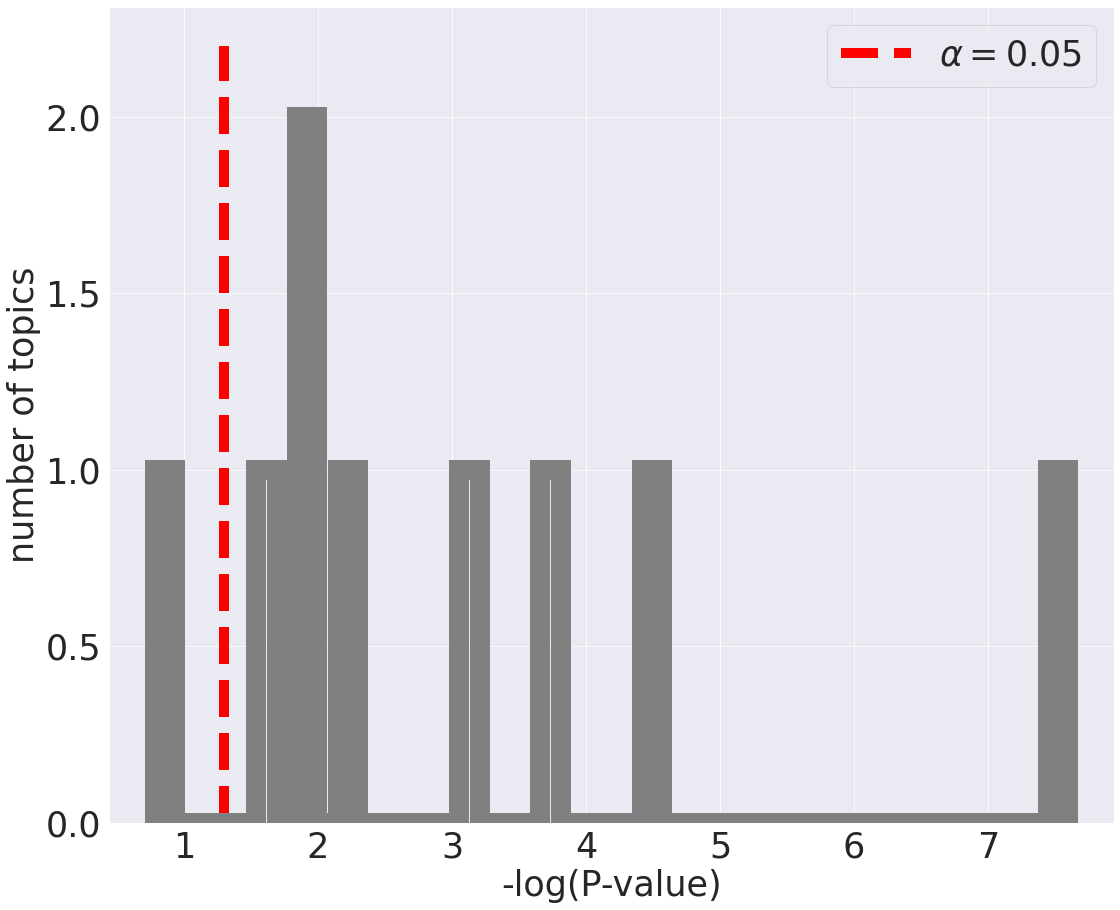

In [61]:
fig = plt.figure(figsize=(18,15))
x = np.arange(1,1+len(topic_pvalues))
c, _, _ = plt.hist(topic_pvalues, histtype='step', lw=20, bins=45, color="gray")
plt.vlines(-np.log10(0.05),0,np.max(c)*1.1, color="red", ls='--', lw=10, label="$\\alpha=0.05$")
plt.xlabel('-log(P-value)', fontsize=35)
plt.ylabel("number of topics", fontsize=35)
#plt.ylim(0,0.055)
#plt.yscale('log')
plt.legend(fontsize=35)
plt.tick_params(which="both",labelsize=35)
fig.savefig("%s/pvalues_across%s_%s_(%d).pdf"%(directory,kind[1],algorithm,l))

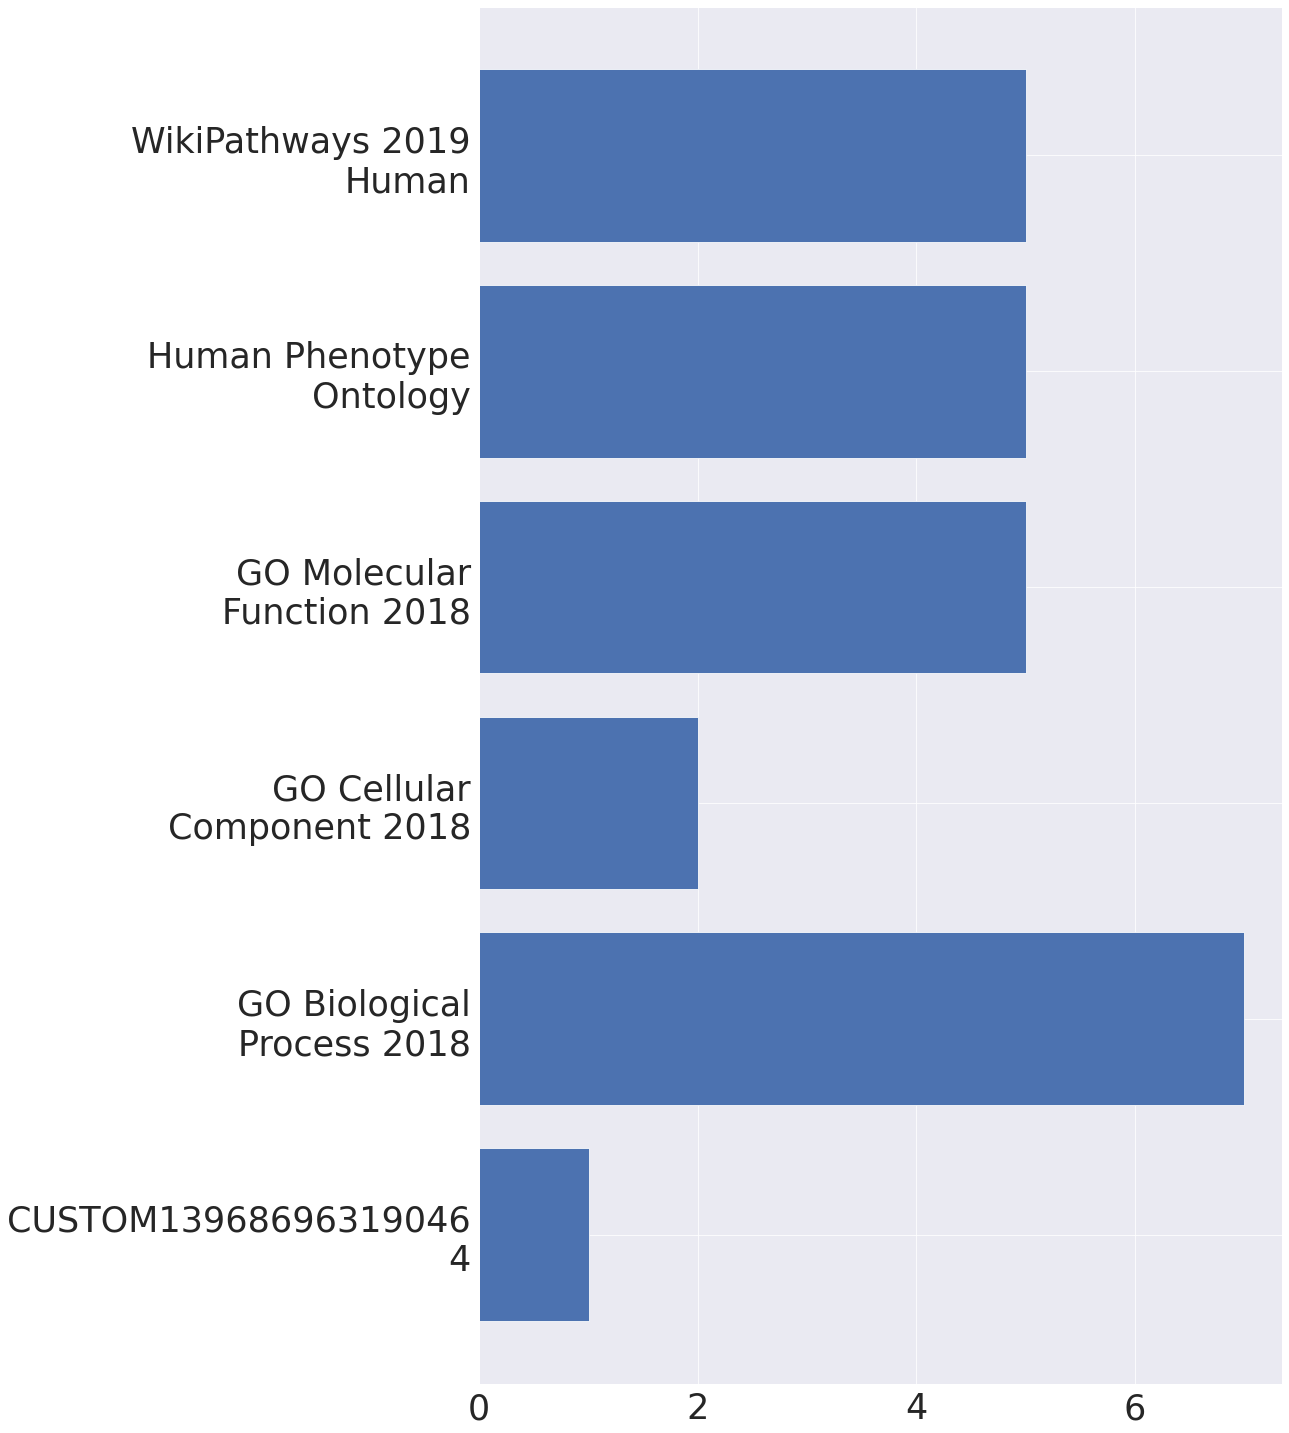

In [62]:
fig = plt.figure(figsize=(18,20))
gos, goscounts = np.unique(topic_gos, return_counts=True)
plt.barh(["\n".join(wrap(str(l).replace('_',' '),20)) for l in gos], goscounts)
plt.yticks(fontsize=15)
plt.tick_params(which="both",labelsize=35)
plt.tight_layout()
plt.show()
fig.savefig("%s/pvalue_categories_%s_(%d).pdf"%(directory,algorithm,l))